In [37]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [40]:
import cv2

In [45]:

img = cv2.imread("/kaggle/input/gtsrb-german-traffic-sign/Train/10/00010_00000_00000.png")

img.shape

(37, 37, 3)

In [38]:
train_path = "/kaggle/input/gtsrb-german-traffic-sign/Train"
test_path = "/kaggle/input/gtsrb-german-traffic-sign/Test"

In [54]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1), shear=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
    
])


In [55]:
train_data = ImageFolder(root=train_path, transform=train_transform)
# test_data = ImageFolder(root=test_path, transform=test_transform)


print("Training images:", len(train_data))
# print("Test images:", len(test_data))
print("Number of classes:", len(train_data.classes))
print("Classes:", train_data.classes)

Training images: 39209
Number of classes: 43
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


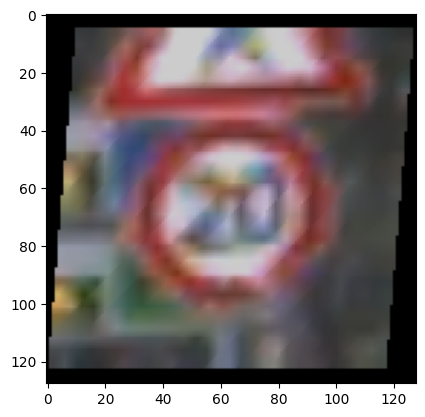

In [53]:
img = train_data[0][0]

img = img * 0.5 + 0.5  
        
np_img = img.permute(1,2,0).numpy()
plt.imshow(np_img)

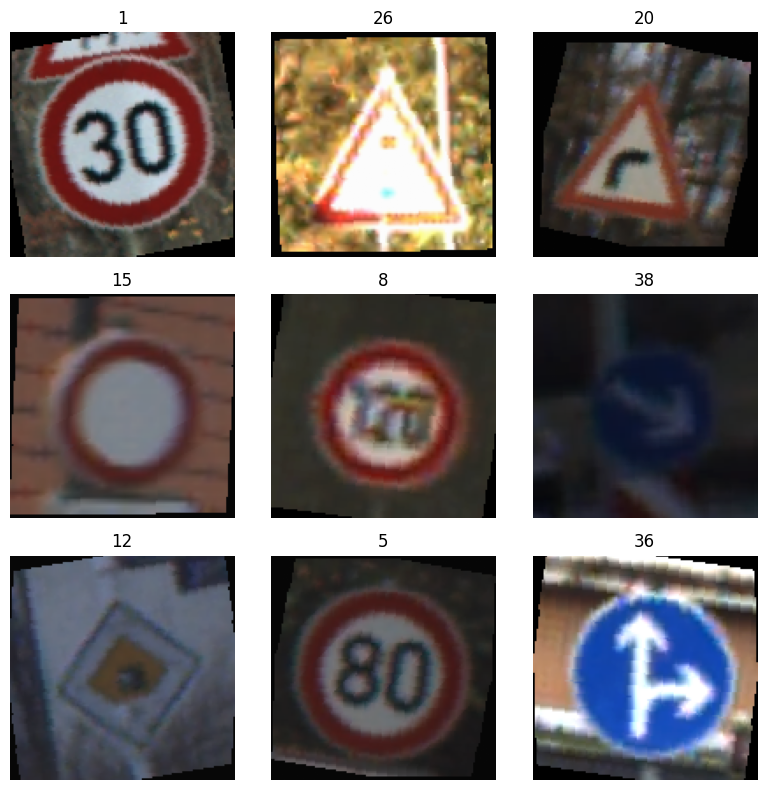

In [56]:
def show_images(dataset, num_images=9):
    num_images = min(num_images, len(dataset))
    
    plt.figure(figsize=(8,8))
    
    for i in range(num_images):
        img, label = dataset[random.randint(0, len(dataset)-1)]
        
        img = img * 0.5 + 0.5  
        
        np_img = img.permute(1,2,0).numpy()
        
        plt.subplot(3,3,i+1)
        plt.imshow(np_img)
        plt.title(dataset.classes[label])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_images(train_data)

In [57]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)


In [59]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 → 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 → 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 → 16
        
        x = x.view(x.size(0), -1)

        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TrafficSignCNN(num_classes=len(train_data.classes)).to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)


In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
  
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    epoch_time = time.time() - start_time
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Time: {epoch_time:.1f}s")

Epoch [1/10] Loss: 1.1985 Train Acc: 0.6345 Time: 100.6s
Epoch [2/10] Loss: 0.2422 Train Acc: 0.9259 Time: 53.3s
Epoch [3/10] Loss: 0.1320 Train Acc: 0.9605 Time: 53.9s
Epoch [4/10] Loss: 0.0933 Train Acc: 0.9708 Time: 55.3s
Epoch [5/10] Loss: 0.0843 Train Acc: 0.9745 Time: 54.9s
Epoch [6/10] Loss: 0.0660 Train Acc: 0.9796 Time: 53.4s
Epoch [7/10] Loss: 0.0706 Train Acc: 0.9783 Time: 54.2s
Epoch [8/10] Loss: 0.0547 Train Acc: 0.9828 Time: 53.8s
Epoch [9/10] Loss: 0.0506 Train Acc: 0.9844 Time: 54.8s
Epoch [10/10] Loss: 0.0499 Train Acc: 0.9850 Time: 53.9s
